In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# ==========================================
# 1. ส่วนประกอบ: Residual Block (ทีมบวก)
# ==========================================
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # ทางลัด (Shortcut) สำหรับปรับขนาดถ้าจำเป็น
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # <--- จุดเด่น ResNet: การบวก
        out = F.relu(out)
        return out

In [3]:
# ==========================================
# 2. ส่วนประกอบ: Dense Block (ทีมต่อ)
# ==========================================
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = torch.cat([x, out], 1) # <--- จุดเด่น DenseNet: การต่อ (Concat)
        return out

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, n_layers):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(n_layers):
            layers.append(DenseLayer(in_channels + i * growth_rate, growth_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(2)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = self.pool(out)
        return out

In [4]:
# ==========================================
# 3. ประกอบร่าง: Hybrid Model
# ==========================================
class HybridResDenseNet(nn.Module):
    def __init__(self, num_classes=10):
        super(HybridResDenseNet, self).__init__()
        
        # 1. Initial Conv
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        
        # 2. Residual Stage (ช่วยเรื่อง Gradient flow ช่วงต้น)
        # 32 -> 32
        self.res_block1 = ResidualBlock(32, 32, stride=1)
        # 32 -> 64 (ลดขนาดภาพเหลือ 16x16)
        self.res_block2 = ResidualBlock(32, 64, stride=2)
        
        # 3. Dense Stage (ช่วยเรื่อง Feature Reuse ช่วงลึก)
        # รับ 64, สร้างเพิ่มชั้นละ 16, จำนวน 4 ชั้น = 64 + (4*16) = 128 channels
        self.dense_block = DenseBlock(in_channels=64, growth_rate=16, n_layers=4)
        
        # ลดขนาดก่อนเข้า FC: 128 -> 64 channels, ภาพลดจาก 16x16 -> 8x8
        self.trans_layer = TransitionLayer(in_channels=128, out_channels=64)

        # 4. Classifier
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        
        # ผ่าน ResNet
        out = self.res_block1(out)
        out = self.res_block2(out)
        
        # ผ่าน DenseNet
        out = self.dense_block(out)
        out = self.trans_layer(out)
        
        # สรุปผล
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [5]:
# ==========================================
# 4. การเตรียมข้อมูล (CIFAR-10)
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 10

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [10]:
# ==========================================
# 5. Training Loop (with Test MSE)
# ==========================================
model = HybridResDenseNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_mse_losses = [] # Changed name to reflect content clearly

print("Start Training Hybrid Model (MSE Strategy)...")

for epoch in range(epochs):
    
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 1. Labels to One-Hot
        labels_one_hot = F.one_hot(labels, num_classes=10).float()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # 2. Softmax for Probability Distribution
        outputs_prob = F.softmax(outputs, dim=1)
        
        loss = criterion(outputs_prob, labels_one_hot)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # --- Evaluation Phase (Calculating MSE) ---
    model.eval()
    running_test_loss = 0.0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # --- [Fix] Apply same logic as training to calculate MSE ---
            
            # 1. Convert Test Labels to One-Hot
            labels_one_hot = F.one_hot(labels, num_classes=10).float()
            
            # 2. Apply Softmax to Test Outputs
            outputs_prob = F.softmax(outputs, dim=1)
            
            # 3. Calculate MSE Loss
            loss = criterion(outputs_prob, labels_one_hot)
            running_test_loss += loss.item()
    
    # Calculate Average Test MSE
    avg_test_mse = running_test_loss / len(testloader)
    test_mse_losses.append(avg_test_mse)
    
    # Print results (No longer %)
    print(f'Epoch [{epoch+1}/{epochs}] Train MSE: {avg_train_loss:.6f} | Test MSE: {avg_test_mse:.6f}')

print('Finished Training')

Start Training Hybrid Model (MSE Strategy)...
Epoch [1/10] Train MSE: 0.064294 | Test MSE: 0.059650
Epoch [2/10] Train MSE: 0.049032 | Test MSE: 0.047299
Epoch [3/10] Train MSE: 0.043157 | Test MSE: 0.044590
Epoch [4/10] Train MSE: 0.038555 | Test MSE: 0.041663
Epoch [5/10] Train MSE: 0.035258 | Test MSE: 0.038324
Epoch [6/10] Train MSE: 0.032344 | Test MSE: 0.036399
Epoch [7/10] Train MSE: 0.029693 | Test MSE: 0.036864
Epoch [8/10] Train MSE: 0.027437 | Test MSE: 0.034356
Epoch [9/10] Train MSE: 0.025898 | Test MSE: 0.031153
Epoch [10/10] Train MSE: 0.024336 | Test MSE: 0.030234
Finished Training


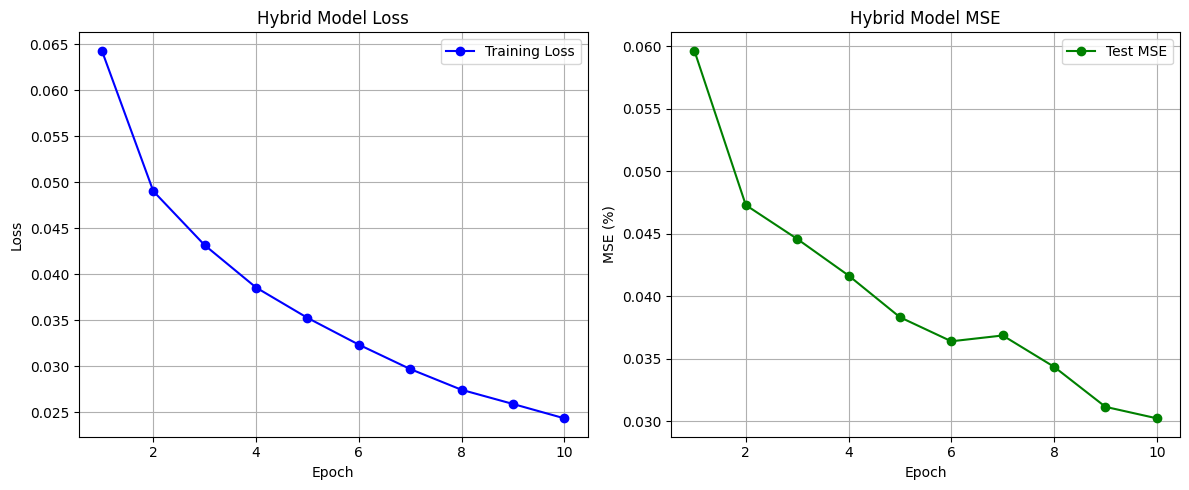

In [11]:
# ==========================================
# 6. Plot Graph
# ==========================================
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, 'b-o', label='Training Loss')
plt.title('Hybrid Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot MSE
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_mse_losses, 'g-o', label='Test MSE')
plt.title('Hybrid Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()